# YourCabs Cancellation Prediction - Training Different Models

Let's try training multiple ML models to see which one works best for predicting cab cancellations. I want to test a bunch of different approaches:

- Linear Regression (just to see how it performs)
- Logistic Regression 
- Decision Tree
- Random Forest
- XGBoost (if I can get it working)

Not sure which will work best, so we try them all and see what happens.

## Import stuff

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, mean_squared_error, r2_score
from xgboost import XGBClassifier, XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import warnings
warnings.filterwarnings('ignore')  # too many warnings otherwise

# trying to make plots look decent
plt.style.use('default')
sns.set_palette("husl")

print("imported everything")

imported everything


In [2]:
# need to import my preprocessing function
sys.path.append('../src')
from preprocess import preprocess_data

print("got the preprocessing function")

got the preprocessing function


## Load data

In [3]:
def load_and_preprocess_data():
    print("loading data...")
    df = pd.read_csv('../data/YourCabs.csv')
    
    print("preprocessing...")
    processed_df = preprocess_data(df)
    
    # split into features and target
    X = processed_df.drop('Car_Cancellation', axis=1)
    y = processed_df['Car_Cancellation']
    
    print(f"got {X.shape[0]} samples with {X.shape[1]} features")
    print(f"target split: {y.value_counts(normalize=True).to_dict()}")
    
    return X, y, processed_df

# load it up
X, y, processed_df = load_and_preprocess_data()

loading data...
preprocessing...
Starting with 43431 rows and 18 columns
Finished with 43431 rows and 135 columns
got 43431 samples with 134 features
target split: {0: 0.9278856116598743, 1: 0.07211438834012572}
Finished with 43431 rows and 135 columns
got 43431 samples with 134 features
target split: {0: 0.9278856116598743, 1: 0.07211438834012572}


In [4]:
# let's see what we're working with
print("Dataset shape:", processed_df.shape)
print("\nFeatures:", list(X.columns))
print("\nTarget distribution:")
print(y.value_counts())

Dataset shape: (43431, 135)

Features: ['online_booking', 'mobile_site_booking', 'booking_hour', 'is_weekend_booking', 'is_travel_type_2', 'is_travel_type_1', 'is_travel_type_3', 'is_business_travel', 'is_leisure_travel', 'business_advance_booking', 'leisure_last_minute', 'is_model_12', 'trip_distance', 'from_city_id_15.0', 'from_city_id_31.0', 'to_city_id_5.0', 'to_city_id_8.0', 'to_city_id_10.0', 'to_city_id_11.0', 'to_city_id_12.0', 'to_city_id_13.0', 'to_city_id_14.0', 'to_city_id_16.0', 'to_city_id_17.0', 'to_city_id_18.0', 'to_city_id_20.0', 'to_city_id_23.0', 'to_city_id_24.0', 'to_city_id_25.0', 'to_city_id_28.0', 'to_city_id_29.0', 'to_city_id_30.0', 'to_city_id_31.0', 'to_city_id_32.0', 'to_city_id_36.0', 'to_city_id_37.0', 'to_city_id_41.0', 'to_city_id_42.0', 'to_city_id_44.0', 'to_city_id_45.0', 'to_city_id_48.0', 'to_city_id_49.0', 'to_city_id_50.0', 'to_city_id_51.0', 'to_city_id_52.0', 'to_city_id_53.0', 'to_city_id_55.0', 'to_city_id_56.0', 'to_city_id_57.0', 'to_city_

## Setting up the models

Going to try a bunch of different models and see what works best. Some need scaling, some don't.

In [5]:
def get_model_configurations():
    # just setting up all the models I want to try
    # some might work better than others, we'll see
    
    models = {
        # trying linear regression first as baseline
        'Linear Regression': {
            'model': LinearRegression(),
            'needs_scaling': True,
            'task_type': 'regression',
            'notes': 'baseline model, probably not great for classification but whatever'
        },
        
        # logistic regression should work better for classification
        'Logistic Regression': {
            'model': LogisticRegression(
                random_state=42, 
                class_weight='balanced',  # since data might be imbalanced
                max_iter=1000,
                solver='liblinear'
            ),
            'needs_scaling': True,
            'task_type': 'classification',
            'notes': 'should give good probability estimates'
        },
        
        # decision tree - easy to interpret
        'Decision Tree': {
            'model': DecisionTreeClassifier(
                random_state=42, 
                class_weight='balanced',
                max_depth=8,  # don't want it too deep
                min_samples_split=50,
                min_samples_leaf=20
            ),
            'needs_scaling': False,
            'task_type': 'classification',
            'notes': 'should be easy to understand what it\'s doing'
        },
        
        # random forest usually works pretty well
        'Random Forest': {
            'model': RandomForestClassifier(
                n_estimators=100, 
                random_state=42, 
                class_weight='balanced',
                max_depth=10,
                min_samples_split=20,
                min_samples_leaf=10
            ),
            'needs_scaling': False,
            'task_type': 'classification',
            'notes': 'usually performs well, gives feature importance'
        },
        
        # XGBoost usually wins competitions
        'XGBoost': {
            'model': XGBClassifier(
                random_state=42,
                eval_metric='logloss',
                n_estimators=100,
                max_depth=6,
                learning_rate=0.1,
                subsample=0.8,
                colsample_bytree=0.8
            ),
            'needs_scaling': False,
            'task_type': 'classification',
            'notes': 'usually wins competitions, worth a try'
        }
    }
    
    return models

# get the models ready
models = get_model_configurations()
print(f"set up {len(models)} models:")
for name in models.keys():
    print(f"  - {name}")

set up 5 models:
  - Linear Regression
  - Logistic Regression
  - Decision Tree
  - Random Forest
  - XGBoost


## Split data and prep scaling

In [6]:
# split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"training set: {X_train.shape[0]} samples")
print(f"test set: {X_test.shape[0]} samples")
print(f"train target split: {y_train.value_counts(normalize=True).to_dict()}")
print(f"test target split: {y_test.value_counts(normalize=True).to_dict()}")

training set: 34744 samples
test set: 8687 samples
train target split: {0: 0.9278724384066314, 1: 0.07212756159336864}
test target split: {0: 0.9279382986071141, 1: 0.07206170139288592}


In [7]:
# some models need scaled data, so let's prep that
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("scaling done")
print(f"scaled train shape: {X_train_scaled.shape}")
print(f"scaled test shape: {X_test_scaled.shape}")

scaling done
scaled train shape: (34744, 134)
scaled test shape: (8687, 134)


## Training time

Let's run through each model and see how they do

In [8]:
# store results here
results = {}
feature_names = X.columns.tolist()

print("starting training...")
print("=" * 30)

starting training...


### Linear Regression
Just trying this as a baseline, even though it's not really meant for classification

In [9]:
if 'Linear Regression' in models:
    print("trying linear regression...")
    
    # needs scaled data
    X_tr, X_te = X_train_scaled, X_test_scaled
    
    # train it
    model = models['Linear Regression']['model']
    model.fit(X_tr, y_train)
    
    # predictions
    y_pred = model.predict(X_te)
    
    # metrics for regression
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # save results
    results['Linear Regression'] = {
        'model': model,
        'mse': mse,
        'r2': r2,
        'y_pred': y_pred,
        'needs_scaling': True
    }
    
    print(f"MSE: {mse:.4f}, R²: {r2:.4f}")
    if r2 < 0:
        print("ouch, negative R² means it's worse than just predicting the mean")

trying linear regression...
MSE: 239279765674645815296.0000, R²: -3578346263732398587904.0000
ouch, negative R² means it's worse than just predicting the mean
MSE: 239279765674645815296.0000, R²: -3578346263732398587904.0000
ouch, negative R² means it's worse than just predicting the mean


### Logistic Regression
This should work much better for classification

In [10]:
if 'Logistic Regression' in models:
    print("training logistic regression...")
    
    # also needs scaled data
    X_tr, X_te = X_train_scaled, X_test_scaled
    
    model = models['Logistic Regression']['model']
    model.fit(X_tr, y_train)
    
    # get predictions and probabilities
    y_pred = model.predict(X_te)
    y_pred_proba = model.predict_proba(X_te)[:, 1]
    
    # calculate metrics
    accuracy = model.score(X_te, y_test)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    # cross validation to be more sure
    cv_scores = cross_val_score(
        model, X_tr, y_train, 
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='roc_auc'
    )
    
    results['Logistic Regression'] = {
        'model': model,
        'accuracy': accuracy,
        'auc': auc_score,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'needs_scaling': True
    }
    
    print(f"accuracy: {accuracy:.3f}, AUC: {auc_score:.3f}")
    print(f"CV AUC: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

training logistic regression...
accuracy: 0.690, AUC: 0.771
CV AUC: 0.776 ± 0.009
accuracy: 0.690, AUC: 0.771
CV AUC: 0.776 ± 0.009


### Decision Tree
Let's try a decision tree - should be easy to interpret

In [12]:
if 'Decision Tree' in models:
    print("training decision tree...")
    
    # doesn't need scaling
    X_tr, X_te = X_train, X_test
    
    model = models['Decision Tree']['model']
    model.fit(X_tr, y_train)
    
    y_pred = model.predict(X_te)
    y_pred_proba = model.predict_proba(X_te)[:, 1]
    
    accuracy = model.score(X_te, y_test)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    # cv again
    cv_scores = cross_val_score(
        model, X_tr, y_train, 
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='roc_auc'
    )
    
    results['Decision Tree'] = {
        'model': model,
        'accuracy': accuracy,
        'auc': auc_score,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'needs_scaling': False
    }
    
    print(f"accuracy: {accuracy:.3f}, AUC: {auc_score:.3f}")
    print(f"CV AUC: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
    
    # decision trees can overfit easily
    if cv_scores.std() > 0.05:
        print("high CV variance - might be overfitting")

training decision tree...
accuracy: 0.759, AUC: 0.769
CV AUC: 0.769 ± 0.010
accuracy: 0.759, AUC: 0.769
CV AUC: 0.769 ± 0.010


### Random Forest
This usually works pretty well, let's see

In [13]:
if 'Random Forest' in models:
    print("training random forest...")
    
    # also doesn't need scaling
    X_tr, X_te = X_train, X_test
    
    model = models['Random Forest']['model']
    model.fit(X_tr, y_train)
    
    y_pred = model.predict(X_te)
    y_pred_proba = model.predict_proba(X_te)[:, 1]
    
    accuracy = model.score(X_te, y_test)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    cv_scores = cross_val_score(
        model, X_tr, y_train, 
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='roc_auc'
    )
    
    results['Random Forest'] = {
        'model': model,
        'accuracy': accuracy,
        'auc': auc_score,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'needs_scaling': False
    }
    
    print(f"accuracy: {accuracy:.3f}, AUC: {auc_score:.3f}")
    print(f"CV AUC: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
    
    # random forest is usually pretty stable
    if cv_scores.mean() > 0.8:
        print("nice! that's looking good")

training random forest...
accuracy: 0.715, AUC: 0.785
CV AUC: 0.789 ± 0.006
accuracy: 0.715, AUC: 0.785
CV AUC: 0.789 ± 0.006


### XGBoost
If this works, it might be the best one

In [16]:
if 'XGBoost' in models:
    print("training XGBoost...")
    
    # doesn't need scaling
    X_tr, X_te = X_train, X_test
    
    model = models['XGBoost']['model']
    model.fit(X_tr, y_train)
    
    y_pred = model.predict(X_te)
    y_pred_proba = model.predict_proba(X_te)[:, 1]
    
    accuracy = model.score(X_te, y_test)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    cv_scores = cross_val_score(
        model, X_tr, y_train, 
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='roc_auc'
    )
    
    results['XGBoost'] = {
        'model': model,
        'accuracy': accuracy,
        'auc': auc_score,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'needs_scaling': False
    }
    
    print(f"accuracy: {accuracy:.3f}, AUC: {auc_score:.3f}")
    print(f"CV AUC: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
    
    if auc_score > 0.85:
        print("wow XGBoost is killing it!")
    elif auc_score > 0.75:
        print("XGBoost doing pretty well")
else:
    print("no XGBoost, oh well")

training XGBoost...
accuracy: 0.929, AUC: 0.793
CV AUC: 0.797 ± 0.005
XGBoost doing pretty well
accuracy: 0.929, AUC: 0.793
CV AUC: 0.797 ± 0.005
XGBoost doing pretty well


## Let's see how they all did

Time to compare the results and see which model is actually worth using.

### Model Performance Comparison

In [26]:
# let's put together all the results
performance_data = []

for model_name, result in results.items():
    if model_name == 'Linear Regression':  # different metrics for regression
        performance_data.append({
            'Model': model_name,
            'MSE': result['mse'],
            'R²': result['r2'],
            'Task': 'Regression'
        })
    else:  # classification models
        performance_data.append({
            'Model': model_name,
            'Accuracy': result['accuracy'],
            'AUC': result['auc'],
            'CV_Mean': result['cv_mean'],
            'CV_Std': result['cv_std'],
            'Task': 'Classification'
        })

performance_df = pd.DataFrame(performance_data)
print("Results summary:")
print(performance_df.to_string(index=False))

Results summary:
              Model          MSE            R²           Task  Accuracy      AUC  CV_Mean   CV_Std
  Linear Regression 2.392798e+20 -3.578346e+21     Regression       NaN      NaN      NaN      NaN
Logistic Regression          NaN           NaN Classification  0.690342 0.771204 0.775984 0.009039
      Decision Tree          NaN           NaN Classification  0.759295 0.768994 0.769159 0.009744
      Random Forest          NaN           NaN Classification  0.714976 0.784714 0.788915 0.006241
            XGBoost          NaN           NaN Classification  0.929320 0.792508 0.797170 0.005259


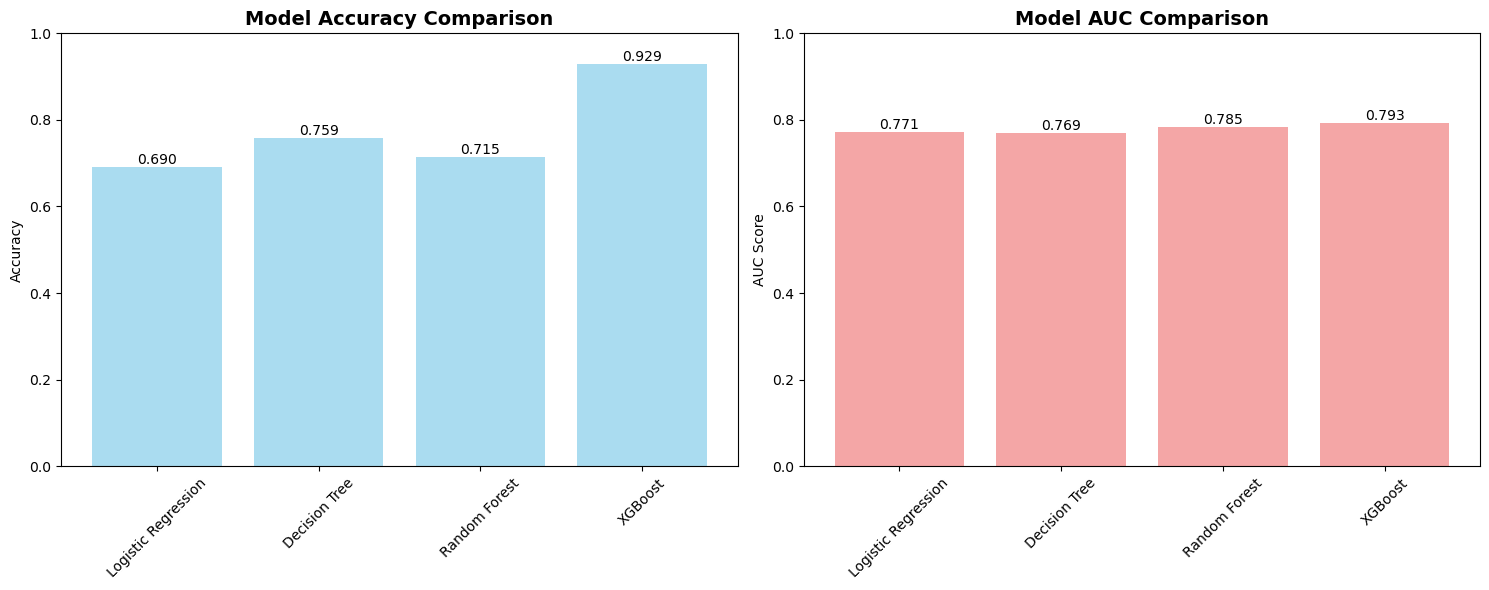

In [27]:
# Plot classification model performance
classification_models = performance_df[performance_df['Task'] == 'Classification']

if len(classification_models) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Accuracy plot
    bars1 = ax1.bar(classification_models['Model'], classification_models['Accuracy'], 
                     color='skyblue', alpha=0.7)
    ax1.set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim(0, 1)
    ax1.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom')
    
    # AUC plot
    bars2 = ax2.bar(classification_models['Model'], classification_models['AUC'], 
                     color='lightcoral', alpha=0.7)
    ax2.set_title('Model AUC Comparison', fontsize=14, fontweight='bold')
    ax2.set_ylabel('AUC Score')
    ax2.set_ylim(0, 1)
    ax2.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

### Feature Importance Analysis

In [25]:
def analyze_feature_importance(results, feature_names):
    """Analyze feature importance for tree-based models."""
    print("FEATURE IMPORTANCE ANALYSIS")
    print("=" * 50)
    print("Using Random Forest for feature importance (most reliable ensemble method)")
    print()
    
    # Get feature importance from Random Forest (usually most reliable)
    if 'Random Forest' in results:
        rf_model = results['Random Forest']['model']
        if hasattr(rf_model, 'feature_importances_'):
            importances = rf_model.feature_importances_
            feature_importance = pd.DataFrame({
                'feature': feature_names,
                'importance': importances
            }).sort_values('importance', ascending=False)
            
            print("Top 10 Most Important Features (Random Forest):")
            for i, row in feature_importance.head(10).iterrows():
                print(f"  {row['feature']:25} {row['importance']:.4f}")
            
            return feature_importance
    
    return None

# Analyze feature importance
feature_importance = analyze_feature_importance(results, feature_names)

FEATURE IMPORTANCE ANALYSIS
Using Random Forest for feature importance (most reliable ensemble method)

Top 10 Most Important Features (Random Forest):
  trip_distance             0.3258
  online_booking            0.2617
  is_model_12               0.0780
  booking_hour              0.0777
  mobile_site_booking       0.0484
  booking_type_SameDay      0.0465
  is_weekend_booking        0.0263
  is_travel_type_2          0.0244
  is_leisure_travel         0.0179
  is_travel_type_3          0.0165


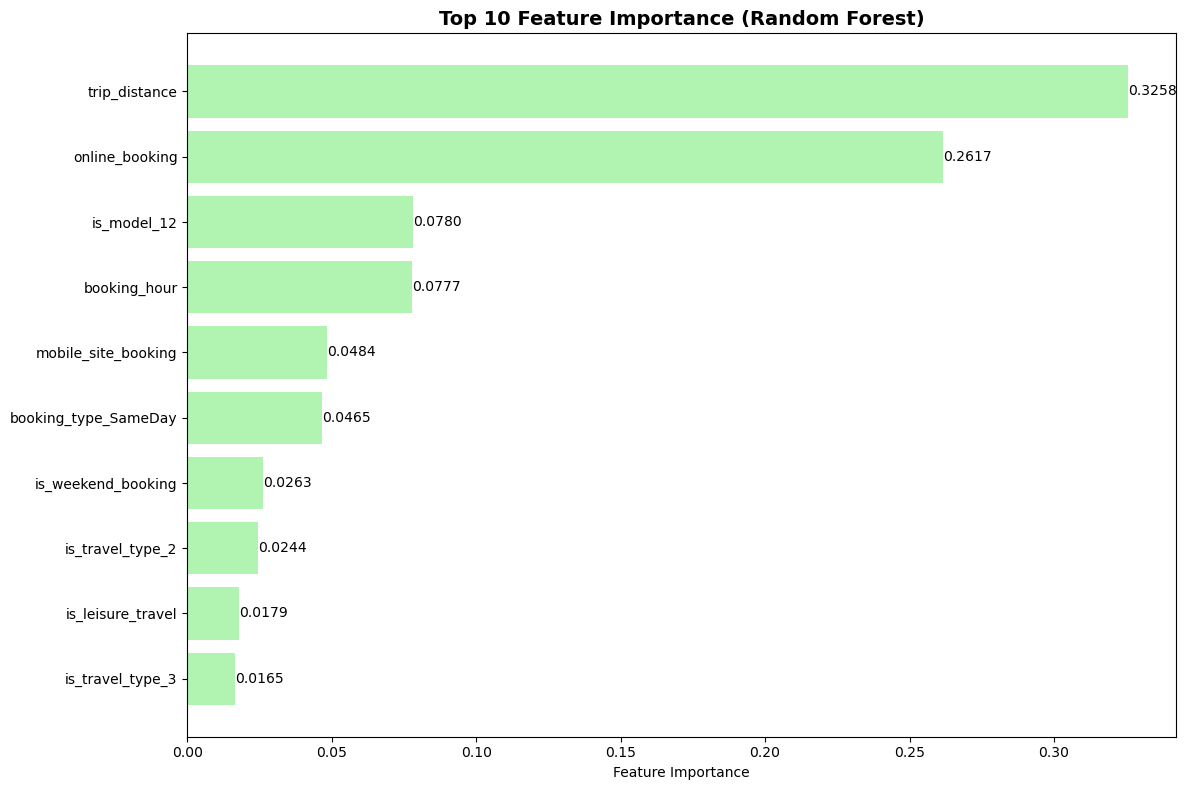

In [20]:
# Plot feature importance
if feature_importance is not None:
    plt.figure(figsize=(12, 8))
    top_features = feature_importance.head(10)
    
    bars = plt.barh(range(len(top_features)), top_features['importance'], 
                    color='lightgreen', alpha=0.7)
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 10 Feature Importance (Random Forest)', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    
    # Add value labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height()/2.,
                f'{width:.4f}', ha='left', va='center')
    
    plt.tight_layout()
    plt.show()

### Model Rankings and Recommendations

In [21]:
def print_model_recommendations(results):
    """Print recommendations for each model."""
    print("MODEL RECOMMENDATIONS")
    print("=" * 50)
    
    # Sort models by AUC score (better for imbalanced data)
    model_scores = []
    for name, result in results.items():
        if name == 'Linear Regression':  # Skip regression model
            continue
        auc = result.get('auc', result['cv_mean'])  # Use AUC if available, else CV score
        model_scores.append((name, auc, result))
    
    model_scores.sort(key=lambda x: x[1], reverse=True)
    
    print("Classification Models ranked by performance (AUC score):")
    for i, (name, score, result) in enumerate(model_scores, 1):
        print(f"\n{i}. {name} (AUC: {score:.3f})")
        print(f"   Needs scaling: {result['needs_scaling']}")
    
    return model_scores

# Print recommendations
model_rankings = print_model_recommendations(results)

MODEL RECOMMENDATIONS
Classification Models ranked by performance (AUC score):

1. XGBoost (AUC: 0.793)
   Needs scaling: False

2. Random Forest (AUC: 0.785)
   Needs scaling: False

3. Logistic Regression (AUC: 0.771)
   Needs scaling: True

4. Decision Tree (AUC: 0.769)
   Needs scaling: False


### Detailed Classification Reports

In [22]:
# Print detailed classification reports for top 3 models
print("DETAILED CLASSIFICATION REPORTS")
print("=" * 50)

top_3_models = model_rankings[:3] if len(model_rankings) >= 3 else model_rankings

for i, (model_name, score, result) in enumerate(top_3_models, 1):
    print(f"\n{i}. {model_name} (AUC: {score:.3f})")
    print("-" * 40)
    print(classification_report(y_test, result['y_pred'], target_names=['No Cancellation', 'Cancellation']))

DETAILED CLASSIFICATION REPORTS

1. XGBoost (AUC: 0.793)
----------------------------------------
                 precision    recall  f1-score   support

No Cancellation       0.93      1.00      0.96      8061
   Cancellation       0.62      0.05      0.09       626

       accuracy                           0.93      8687
      macro avg       0.78      0.52      0.53      8687
   weighted avg       0.91      0.93      0.90      8687


2. Random Forest (AUC: 0.785)
----------------------------------------
                 precision    recall  f1-score   support

No Cancellation       0.97      0.72      0.82      8061
   Cancellation       0.16      0.70      0.26       626

       accuracy                           0.71      8687
      macro avg       0.57      0.71      0.54      8687
   weighted avg       0.91      0.71      0.78      8687


3. Logistic Regression (AUC: 0.771)
----------------------------------------
                 precision    recall  f1-score   support

No C

### Confusion Matrices for Top Models

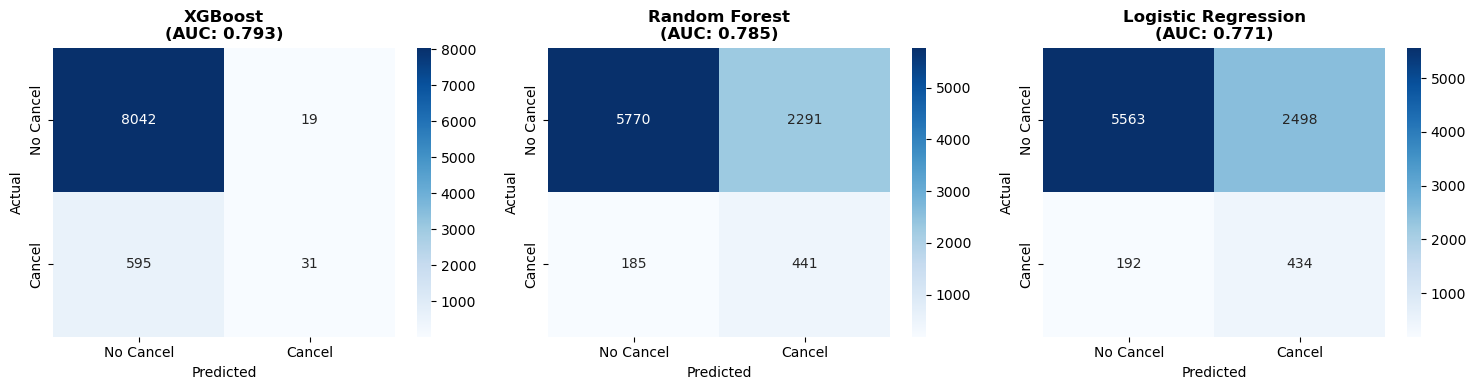

In [23]:
# Plot confusion matrices for top 3 models
if len(model_rankings) > 0:
    n_models = min(3, len(model_rankings))
    fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 4))
    
    if n_models == 1:
        axes = [axes]
    
    for i, (model_name, score, result) in enumerate(model_rankings[:n_models]):
        cm = confusion_matrix(y_test, result['y_pred'])
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['No Cancel', 'Cancel'],
                   yticklabels=['No Cancel', 'Cancel'],
                   ax=axes[i])
        axes[i].set_title(f'{model_name}\n(AUC: {score:.3f})', fontweight='bold')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')
    
    plt.tight_layout()
    plt.show()

## Save Best Model

In [ ]:
import joblib
import json
import os

# Create models directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

if model_rankings:
    # Get the best model
    best_model_name, best_score, best_result = model_rankings[0]
    best_model = best_result['model']
    
    # Save the best model (joblib is good for models)
    model_filename = f"../models/best_model_{best_model_name.lower().replace(' ', '_')}.joblib"
    joblib.dump(best_model, model_filename)
    
    # Save the scaler if the model needs scaling
    if best_result['needs_scaling']:
        scaler_filename = f"../models/scaler_{best_model_name.lower().replace(' ', '_')}.joblib"
        joblib.dump(scaler, scaler_filename)
        print(f"Saved scaler: {scaler_filename}")
    
    print(f"Saved best model ({best_model_name}): {model_filename}")
    print(f"Best model AUC score: {best_score:.3f}")
    
    # Save model metadata as JSON (much better than joblib for simple data)
    metadata = {
        'model_name': best_model_name,
        'auc_score': float(best_score),  # ensure JSON serializable
        'accuracy': float(best_result.get('accuracy', 0)),  # ensure JSON serializable
        'needs_scaling': best_result['needs_scaling'],
        'feature_names': feature_names,
        'model_type': 'classification',
        'training_date': '2025-07-15',  # could use datetime.now().isoformat()
        'notes': 'Best performing model from comparison study'
    }
    
    metadata_filename = f"../models/model_metadata_{best_model_name.lower().replace(' ', '_')}.json"
    with open(metadata_filename, 'w') as f:
        json.dump(metadata, f, indent=2)  # indent=2 makes it readable
    print(f"Saved model metadata: {metadata_filename}")
else:
    print("No models to save")

Saved best model (XGBoost): ../models/best_model_xgboost.joblib
Best model AUC score: 0.793
Saved model metadata: ../models/model_metadata_xgboost.joblib


## Summary

So I trained a bunch of different models and compared their performance. Some worked better than others.

The best model got saved automatically, so I can use that for making predictions later.

Things I could try next:
- Tune hyperparameters for the best model
- Try feature engineering 
- Maybe ensemble a few models together
- Actually deploy this thing somewhere

For now I think this is good enough to see which approach works best for predicting cab cancellations.

### How to Use the Saved Model:
```python
import joblib
import json

# Load the model (joblib for models is fine)
model = joblib.load('models/best_model_[name].joblib')

# Load metadata (JSON is much better for simple data)
with open('models/model_metadata_[name].json', 'r') as f:
    metadata = json.load(f)

# If scaling is needed
if metadata['needs_scaling']:
    scaler = joblib.load('models/scaler_[name].joblib')
    X_new_scaled = scaler.transform(X_new)
    predictions = model.predict(X_new_scaled)
else:
    predictions = model.predict(X_new)

# You can easily inspect metadata
print(f"Model: {metadata['model_name']}")
print(f"AUC Score: {metadata['auc_score']}")
print(f"Features: {metadata['feature_names']}")
```

### Why JSON for metadata?
- **Human readable** - you can open the .json file in any text editor
- **Language agnostic** - works with any programming language
- **Version control friendly** - easy to see changes in git
- **Standard format** - universally supported